=== RAW DATA INFO ===
Shape: (97986, 12)

Columns:
 ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'tip_amount', 'total_amount']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97986 entries, 0 to 97985
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               97986 non-null  int64  
 1   tpep_pickup_datetime   97986 non-null  object 
 2   tpep_dropoff_datetime  97986 non-null  object 
 3   passenger_count        97986 non-null  int64  
 4   trip_distance          97986 non-null  float64
 5   pickup_longitude       97986 non-null  float64
 6   pickup_latitude        97986 non-null  float64
 7   dropoff_longitude      97986 non-null  float64
 8   dropoff_latitude       97986 non-null  float64
 9   fare_amount            97986 non

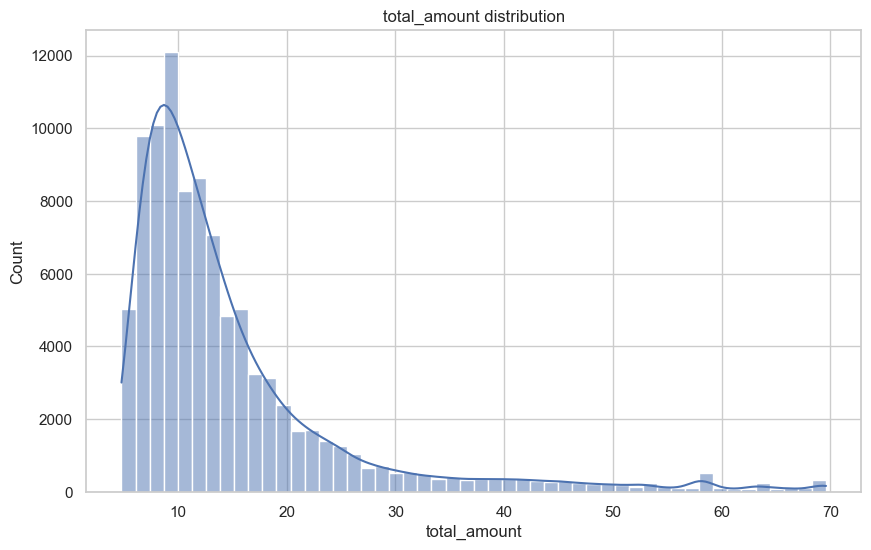

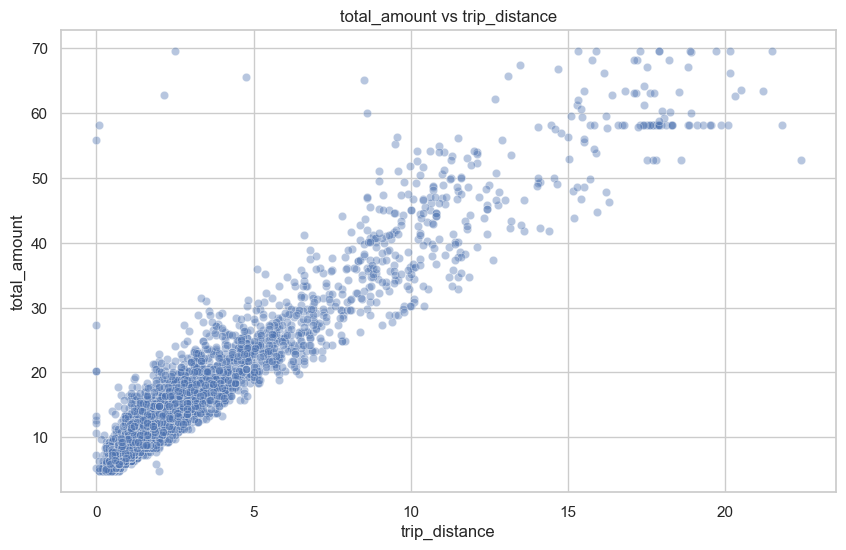

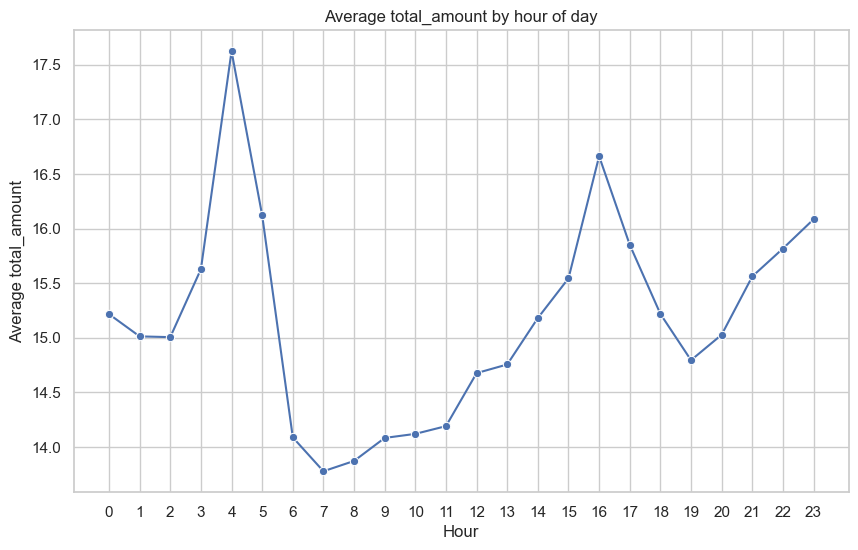

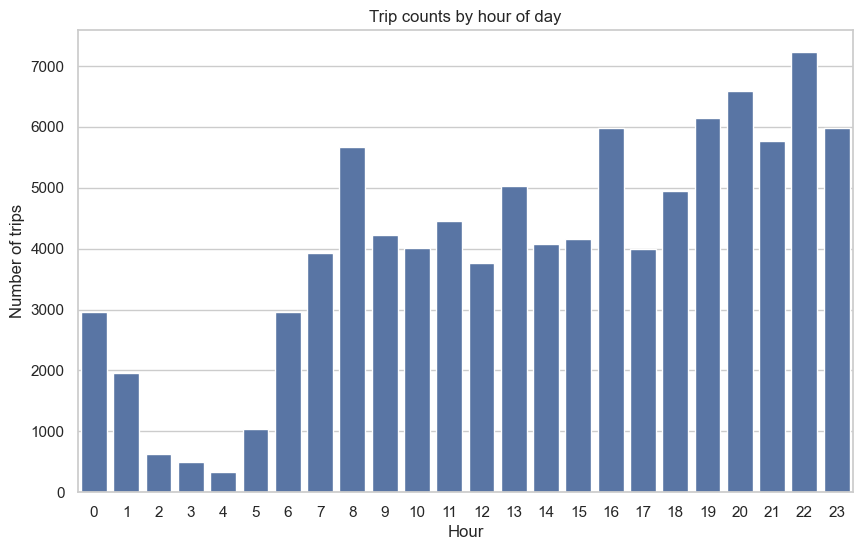

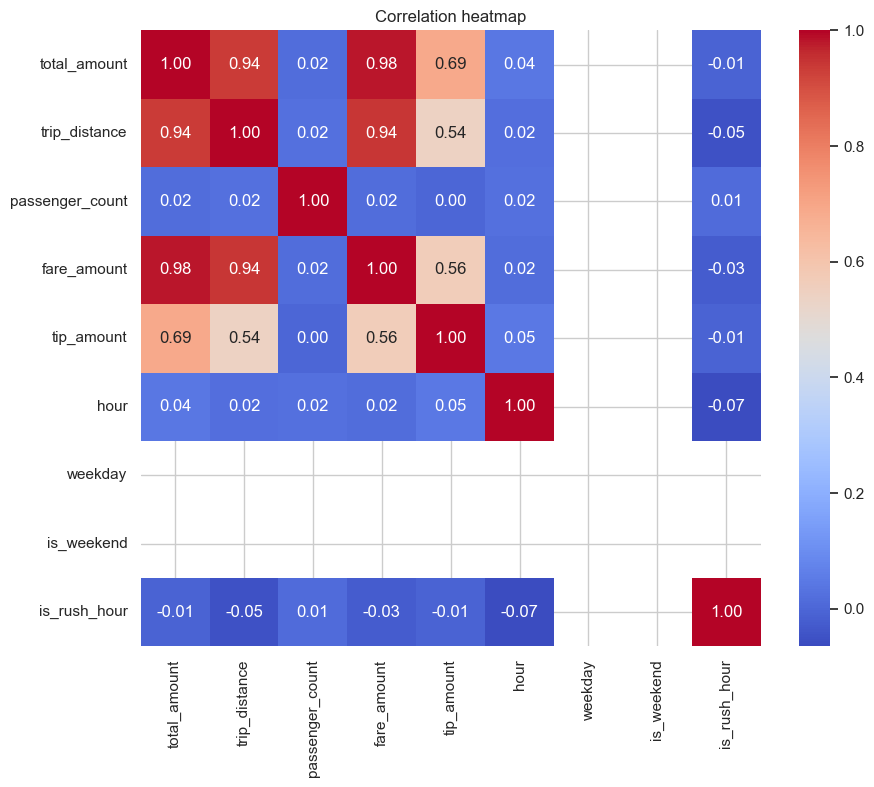


Temporal split using 'tpep_pickup_datetime'
Train: (77013, 18), Test: (19254, 18)

Numeric columns to scale: ['passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'tip_amount', 'hour', 'day', 'month', 'weekday', 'is_weekend', 'is_rush_hour']

=== PHASE 1 DONE ===
Saved train data to: data/processed_train_phase1.csv
Saved test data to:  data/processed_test_phase1.csv


In [6]:
# ============================================================
# PHASE 1: DATA PREPROCESSING & EDA
# Dataset: NYC Yellow Taxi-style data
# ============================================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

# Plot config
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_theme(style="whitegrid")  # <- no deprecation warning

RANDOM_STATE = 42

# -----------------------
# CONFIG FOR YOUR DATASET
# -----------------------
TARGET_COL = "total_amount"             # "price" equivalent
TIME_COL = "tpep_pickup_datetime"
DISTANCE_COL = "trip_distance"
LON_LAT_COLS = {
    "pickup_longitude": "pickup_longitude",
    "pickup_latitude": "pickup_latitude",
    "dropoff_longitude": "dropoff_longitude",
    "dropoff_latitude": "dropoff_latitude",
}


# ============================================================
# Helper functions
# ============================================================

def basic_info(df):
    print("Shape:", df.shape)
    print("\nColumns:\n", df.columns.tolist())
    print("\nInfo:")
    print(df.info())
    print("\nMissing values:")
    print(df.isna().sum().sort_values(ascending=False))


def handle_missing_values(df, target_col=TARGET_COL, distance_col=DISTANCE_COL):
    """
    Basic missing value handling for this taxi dataset.
    - Drop rows with missing target (total_amount).
    - Fill trip_distance with median.
    """
    df = df.copy()

    # 1. Drop rows where target is missing
    if target_col not in df.columns:
        raise ValueError(f"Column '{target_col}' not found in dataframe.")

    before = len(df)
    df = df.dropna(subset=[target_col])
    after = len(df)
    print(f"Dropped {before - after} rows with missing {target_col}.")

    # 2. Distance
    if distance_col in df.columns:
        median_dist = df[distance_col].median()
        df[distance_col] = df[distance_col].fillna(median_dist)

    # 3. Tip & fare: if missing, fill with 0 (rare)
    for col in ["fare_amount", "tip_amount"]:
        if col in df.columns:
            df[col] = df[col].fillna(0)

    # 4. Passenger count: if missing, fill with mode
    if "passenger_count" in df.columns:
        mode_pass = df["passenger_count"].mode(dropna=True)
        if not mode_pass.empty:
            df["passenger_count"] = df["passenger_count"].fillna(mode_pass[0])

    return df


def add_time_features(df, time_col=TIME_COL):
    """
    Create datetime-based features:
    - pickup_datetime (as datetime)
    - hour, day, month, weekday, is_weekend
    """
    df = df.copy()

    if time_col not in df.columns:
        raise ValueError(f"Time column '{time_col}' not found in dataframe.")

    df[time_col] = pd.to_datetime(df[time_col])

    df["hour"] = df[time_col].dt.hour
    df["day"] = df[time_col].dt.day
    df["month"] = df[time_col].dt.month
    df["weekday"] = df[time_col].dt.weekday  # 0=Mon, 6=Sun
    df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)

    # Optional "rush hour" indicator
    df["is_rush_hour"] = (
        df["hour"].between(7, 9) | df["hour"].between(16, 19)
    ).astype(int)

    return df


def handle_outliers_target(df, target_col=TARGET_COL, lower_q=0.01, upper_q=0.99):
    """
    Remove extreme outliers for the target column (total_amount).
    """
    df = df.copy()

    q_low = df[target_col].quantile(lower_q)
    q_high = df[target_col].quantile(upper_q)

    before = len(df)
    df = df[(df[target_col] >= q_low) & (df[target_col] <= q_high)]
    after = len(df)

    print(f"Removed {before - after} rows as {target_col} outliers.")
    print(f"{target_col} range after filtering: {df[target_col].min()} - {df[target_col].max()}")
    return df


def temporal_train_test_split(df, time_col=TIME_COL, test_size=0.2):
    """
    Temporal split: oldest data → train, newest → test.
    """
    df = df.copy().sort_values(by=time_col)
    cutoff_index = int((1 - test_size) * len(df))

    train_df = df.iloc[:cutoff_index]
    test_df = df.iloc[cutoff_index:]

    print(f"\nTemporal split using '{time_col}'")
    print(f"Train: {train_df.shape}, Test: {test_df.shape}")

    return train_df, test_df


def scale_numeric(train_df, test_df, numeric_cols):
    scaler = RobustScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
    return train_df, test_df, scaler


# ============================================================
# EDA functions
# ============================================================

def plot_target_distribution(df, target_col=TARGET_COL):
    plt.figure()
    sns.histplot(df[target_col], bins=50, kde=True)
    plt.title(f"{target_col} distribution")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.show()


def plot_target_vs_distance(df, target_col=TARGET_COL, distance_col=DISTANCE_COL):
    if distance_col not in df.columns:
        print(f"No '{distance_col}' column, skipping target vs distance plot.")
        return

    plt.figure()
    sns.scatterplot(
        x=distance_col,
        y=target_col,
        data=df.sample(min(5000, len(df)), random_state=RANDOM_STATE),
        alpha=0.4,
    )
    plt.title(f"{target_col} vs {distance_col}")
    plt.xlabel(distance_col)
    plt.ylabel(target_col)
    plt.show()


def plot_target_by_hour(df, target_col=TARGET_COL):
    if "hour" not in df.columns:
        print("No 'hour' column, skipping target by hour plot.")
        return

    hourly_stats = df.groupby("hour")[target_col].mean().reset_index()
    plt.figure()
    sns.lineplot(x="hour", y=target_col, data=hourly_stats, marker="o")
    plt.title(f"Average {target_col} by hour of day")
    plt.xlabel("Hour")
    plt.ylabel(f"Average {target_col}")
    plt.xticks(range(0, 24))
    plt.show()


def plot_trip_counts_by_hour(df):
    if "hour" not in df.columns:
        print("No 'hour' column, skipping trip counts by hour.")
        return

    counts = df["hour"].value_counts().sort_index()
    plt.figure()
    sns.barplot(x=counts.index, y=counts.values)
    plt.title("Trip counts by hour of day")
    plt.xlabel("Hour")
    plt.ylabel("Number of trips")
    plt.show()


def plot_correlation_heatmap(df, cols):
    plt.figure(figsize=(10, 8))
    corr = df[cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation heatmap")
    plt.show()


# ============================================================
# MAIN PIPELINE
# ============================================================

if __name__ == "__main__":
    # ---------------------------------------
    # 1. Load data
    # ---------------------------------------
    DATA_PATH =  "https://raw.githubusercontent.com/uber-web/kepler.gl-data/master/nyctrips/data.csv"
    df = pd.read_csv(DATA_PATH)

    print("=== RAW DATA INFO ===")
    basic_info(df)

    # Optional: sample to speed up
    if len(df) > 200_000:
        df = df.sample(200_000, random_state=RANDOM_STATE).reset_index(drop=True)
        print("\nSampled to 200,000 rows for development.")

    # ---------------------------------------
    # 2. Clean missing values
    # ---------------------------------------
    df = handle_missing_values(df, target_col=TARGET_COL, distance_col=DISTANCE_COL)

    # ---------------------------------------
    # 3. Add time features
    # ---------------------------------------
    df = add_time_features(df, time_col=TIME_COL)

    # ---------------------------------------
    # 4. Remove outliers in target
    # ---------------------------------------
    df = handle_outliers_target(df, target_col=TARGET_COL, lower_q=0.01, upper_q=0.99)

    # ---------------------------------------
    # 5. Quick EDA plots
    # ---------------------------------------
    print("\n=== RUNNING EDA PLOTS ===")
    plot_target_distribution(df, target_col=TARGET_COL)
    plot_target_vs_distance(df, target_col=TARGET_COL, distance_col=DISTANCE_COL)
    plot_target_by_hour(df, target_col=TARGET_COL)
    plot_trip_counts_by_hour(df)

    # Correlation between key numeric columns
    possible_corr_cols = [
        TARGET_COL,
        DISTANCE_COL,
        "passenger_count",
        "fare_amount",
        "tip_amount",
        "hour",
        "weekday",
        "is_weekend",
        "is_rush_hour",
    ]
    corr_cols = [c for c in possible_corr_cols if c in df.columns]
    if len(corr_cols) >= 2:
        plot_correlation_heatmap(df, corr_cols)

    # ---------------------------------------
    # 6. Temporal train/test split
    # ---------------------------------------
    train_df, test_df = temporal_train_test_split(df, time_col=TIME_COL, test_size=0.2)

    # ---------------------------------------
    # 7. Prepare for ML (drop unused cols, scale)
    # ---------------------------------------
    # Columns we don't want as features (IDs, raw timestamps, dropoff time maybe)
    drop_cols = [
        TIME_COL,
        "tpep_dropoff_datetime",
        "VendorID",
    ]
    drop_cols = [c for c in drop_cols if c in train_df.columns]

    train_df = train_df.drop(columns=drop_cols, errors="ignore")
    test_df = test_df.drop(columns=drop_cols, errors="ignore")

    # Split X/y
    y_train = train_df[TARGET_COL]
    y_test = test_df[TARGET_COL]

    X_train = train_df.drop(columns=[TARGET_COL])
    X_test = test_df.drop(columns=[TARGET_COL])

    # Numeric columns to scale
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    print("\nNumeric columns to scale:", numeric_cols)

    X_train, X_test, scaler = scale_numeric(X_train, X_test, numeric_cols)

    # ---------------------------------------
    # 8. Save processed data
    # ---------------------------------------
    PROCESSED_TRAIN_PATH = "data/processed_train_phase1.csv"
    PROCESSED_TEST_PATH = "data/processed_test_phase1.csv"

    processed_train = X_train.copy()
    processed_train[TARGET_COL] = y_train

    processed_test = X_test.copy()
    processed_test[TARGET_COL] = y_test

    processed_train.to_csv(PROCESSED_TRAIN_PATH, index=False)
    processed_test.to_csv(PROCESSED_TEST_PATH, index=False)

    print("\n=== PHASE 1 DONE ===")
    print(f"Saved train data to: {PROCESSED_TRAIN_PATH}")
    print(f"Saved test data to:  {PROCESSED_TEST_PATH}")
